# Import Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

# Loading Data

In [46]:
df = pd.read_csv("dataset/clean_col_dataset.csv")

In [47]:
# check col names
df.columns

Index(['customerid', 'age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn'],
      dtype='object')

In [48]:
# check col types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customerid         64374 non-null  int64 
 1   age                64374 non-null  int64 
 2   gender             64374 non-null  object
 3   tenure             64374 non-null  int64 
 4   usage_frequency    64374 non-null  int64 
 5   support_calls      64374 non-null  int64 
 6   payment_delay      64374 non-null  int64 
 7   subscription_type  64374 non-null  object
 8   contract_length    64374 non-null  object
 9   total_spend        64374 non-null  int64 
 10  last_interaction   64374 non-null  int64 
 11  churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


In [49]:
# filter df, churn = 1
df = df[df["churn"] == 1]

In [50]:
df["churn"].value_counts()

churn
1    30493
Name: count, dtype: int64

# Feature

## Feature Selection

In [51]:
# copy df to dataframe named df_model
df_model = df.copy()

In [52]:
for col in df_model.columns:
    contingency_table = pd.crosstab(df_model[col],df_model["churn"])
    print(f"column {col} {stats.chi2_contingency(contingency_table).pvalue}")

column customerid 1.0
column age 1.0
column gender 1.0
column tenure 1.0
column usage_frequency 1.0
column support_calls 1.0
column payment_delay 1.0
column subscription_type 1.0
column contract_length 1.0
column total_spend 1.0
column last_interaction 1.0
column churn 1.0


In [53]:
# drop customerid, last_interaction
df_model = df_model.drop(columns=["customerid", "last_interaction"])

In [54]:
df_model.columns

Index(['age', 'gender', 'tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'subscription_type', 'contract_length', 'total_spend',
       'churn'],
      dtype='object')

## Handling Missing Value

In [55]:
# check missing value
df_model.isnull().sum()

age                  0
gender               0
tenure               0
usage_frequency      0
support_calls        0
payment_delay        0
subscription_type    0
contract_length      0
total_spend          0
churn                0
dtype: int64

In [56]:
# check data row missing value
df_model[df_model.isnull().any(axis=1)]

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,churn


In [57]:
# drop missing value
df_model = df_model.dropna()

In [58]:
# check missing value
df_model.isnull().sum()

age                  0
gender               0
tenure               0
usage_frequency      0
support_calls        0
payment_delay        0
subscription_type    0
contract_length      0
total_spend          0
churn                0
dtype: int64

## Handling Outliers

In [59]:
# check col names
df_model.columns

Index(['age', 'gender', 'tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'subscription_type', 'contract_length', 'total_spend',
       'churn'],
      dtype='object')

In [60]:
# init col to check
num_col = ['age', 'tenure', 'usage_frequency', 'support_calls',
           'payment_delay', 'total_spend']

# init col_outliers
col_outliers = []

# init df_outliers
df_outliers = pd.DataFrame()

print("Outliers Overview:")
print("")

for col in num_col:
    print(col)

    # skewness
    skew_col = df_model[col].skew()
    print(f"skewness {col}       = {skew_col}")
    if skew_col > 0.5 or skew_col < -0.5:
        print("skewed")
    else:
        print("normal")

    # q1 q3 iqr
    q1_col = df_model[col].quantile(0.25)
    q3_col = df_model[col].quantile(0.75)
    iqr_col = q3_col - q1_col

    # lower upper boundary
    ub_col = q3_col + 1.5 * iqr_col
    lb_col = q1_col - 1.5 * iqr_col

    print(f"upper boundary {col} = {ub_col}")
    print(f"lower boundary {col} = {lb_col}")

    # outliers
    outlier_col = df_model[col][(df_model[col] < lb_col) | (df_model[col] > ub_col)]

    if len(outlier_col) > 0:
        # count and percentage of outliers
        persentase_outliers = len(outlier_col) / len(df_model[col]) * 100
        print(f"terdapat outliers sebanyak {len(outlier_col)} row")
        print(f"dengan persentase {(persentase_outliers):.2f}%")

        # min max outliers
        min_outlier_col = outlier_col.min()
        max_outlier_col = outlier_col.max()
        print(f"min outlier_{col} = {min_outlier_col}")
        print(f"max outlier_{col} = {max_outlier_col}")

        col_outliers.append({"column": col, "outliers": len(outlier_col), "%": f"{persentase_outliers:.2f}"})
        df_outliers = pd.concat([df_outliers, outlier_col], axis=1)
    else:
        print(f"tidak ada outliers untuk kolom {col}")

    print("")

# col_outliers to dataframe
col_outliers = pd.DataFrame(col_outliers)


Outliers Overview:

age
skewness age       = -0.13301652275146242
normal
upper boundary age = 91.0
lower boundary age = -5.0
tidak ada outliers untuk kolom age

tenure
skewness tenure       = -0.4172452471873793
normal
upper boundary tenure = 85.0
lower boundary tenure = -11.0
tidak ada outliers untuk kolom tenure

usage_frequency
skewness usage_frequency       = 0.15868995203080272
normal
upper boundary usage_frequency = 47.5
lower boundary usage_frequency = -20.5
tidak ada outliers untuk kolom usage_frequency

support_calls
skewness support_calls       = -0.6372430947254014
skewed
upper boundary support_calls = 15.0
lower boundary support_calls = -1.0
tidak ada outliers untuk kolom support_calls

payment_delay
skewness payment_delay       = -1.2979000507642777
skewed
upper boundary payment_delay = 39.0
lower boundary payment_delay = 7.0
terdapat outliers sebanyak 1090 row
dengan persentase 3.57%
min outlier_payment_delay = 0
max outlier_payment_delay = 6

total_spend
skewness total_s

In [61]:
# show column has an outliers
col_outliers

,column,outliers,%
0,payment_delay,1090,3.57


insight:
- tidak ada outliers pada kolom numerik

## Scaling

In [62]:
df_model_num = df_model[num_col]
df_model_num

,age,tenure,usage_frequency,support_calls,payment_delay,total_spend
0,22,25,14,4,27,598
6,47,37,15,9,28,574
10,46,42,27,9,21,526
15,35,1,3,7,3,677
25,65,58,7,3,30,166
...,...,...,...,...,...,...
64369,45,33,12,6,21,947
64370,37,6,1,5,22,923
64371,25,39,14,8,30,327
64372,50,18,19,7,22,540


In [63]:
# scaling df_model[num_col]
scaler = MinMaxScaler()
df_model_num_scaled = scaler.fit_transform(df_model_num)

## Encoding

### Nominal

In [64]:
# nominal categoric cols
cat_col_n = ["gender", "churn"]
df_model_cat_n = df_model[cat_col_n]
df_model_cat_n

,gender,churn
0,Female,1
6,Female,1
10,Female,1
15,Female,1
25,Female,1
...,...,...
64369,Female,1
64370,Male,1
64371,Male,1
64372,Female,1


In [65]:
# init OneHotEncoder
encoder_cat_n = OneHotEncoder()

# fit transform df_model_cat_n
df_model_cat_n_encoded = encoder_cat_n.fit_transform(df_model_cat_n).toarray()

### Ordinal

In [66]:
# nominal categoric cols
cat_col_o = ["subscription_type", "contract_length"]
df_model_cat_o = df_model[cat_col_o]
df_model_cat_o

,subscription_type,contract_length
0,Basic,Monthly
6,Basic,Quarterly
10,Standard,Annual
15,Basic,Monthly
25,Premium,Annual
...,...,...
64369,Basic,Quarterly
64370,Standard,Annual
64371,Premium,Monthly
64372,Standard,Monthly


In [67]:
# check subscription_type values
df_model["subscription_type"].value_counts()

subscription_type
Basic       10356
Standard    10177
Premium      9960
Name: count, dtype: int64

In [68]:
# check contract_length values
df_model["contract_length"].value_counts()

contract_length
Monthly      11421
Annual        9895
Quarterly     9177
Name: count, dtype: int64

In [69]:
# init value order
subscription_type_order = ["Basic", "Standard", "Premium"]
contract_length_order = ["Monthly", "Quarterly", "Annual"]

In [70]:
# init OrdinalEncoder
encoder_cat_o = OrdinalEncoder(categories=[subscription_type_order, contract_length_order])

# fit transform encoder_cat_o
df_model_cat_o = encoder_cat_o.fit_transform(df_model_cat_o)

## Concat

In [71]:
# merging
df_model_final = np.concatenate(
    [df_model_num_scaled, df_model_cat_n_encoded, df_model_cat_o], axis=1
)

In [72]:
# check df_model_final
df_model_final

array([[0.08510638, 0.40677966, 0.44827586, ..., 1.        , 0.        ,
        0.        ],
       [0.61702128, 0.61016949, 0.48275862, ..., 1.        , 0.        ,
        1.        ],
       [0.59574468, 0.69491525, 0.89655172, ..., 1.        , 1.        ,
        2.        ],
       ...,
       [0.14893617, 0.6440678 , 0.44827586, ..., 1.        , 2.        ,
        0.        ],
       [0.68085106, 0.28813559, 0.62068966, ..., 1.        , 1.        ,
        0.        ],
       [0.72340426, 0.74576271, 0.48275862, ..., 1.        , 1.        ,
        0.        ]])

## Dimensionality Reduction

In [73]:
# pca fit
pca = PCA()
pca.fit(df_model_final)

PCA()

In [74]:
# components length
len_components = len(pca.explained_variance_ratio_)
len_components

11

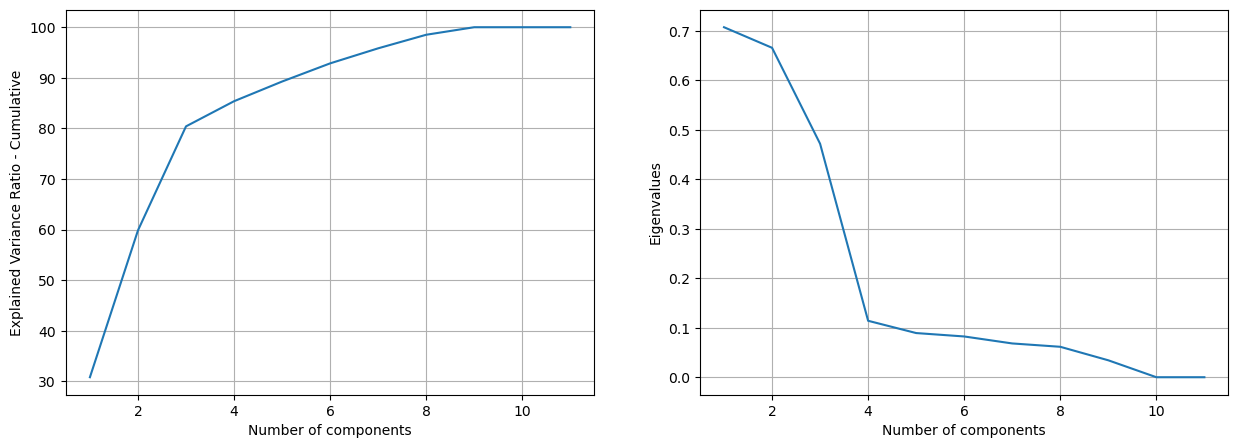

In [75]:
# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(range(1, len_components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained Variance Ratio - Cumulative")

# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(range(1, len_components + 1), pca.explained_variance_)
plt.xlabel("Number of components")
plt.ylabel("Eigenvalues")

plt.show()

In [76]:
# Check n_features to keep 90% information
cumsum = np.cumsum(pca.explained_variance_ratio_)
n_features = np.argmax(cumsum >= 0.90) + 1
n_features

6

In [77]:
# train model
pca = PCA(n_components=n_features)
pca.fit(df_model_final)

df_model_final_pca = pca.transform(df_model_final)

# Model Definition

## Elbow Plot

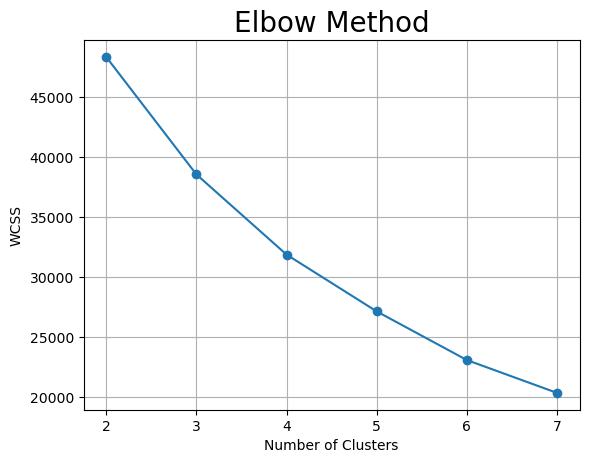

In [78]:
# Find the optimal number of clusters using Elbow Method
wcss = []
random_state = 13
max_cluster = 7
max_iter = 300
n_init = 10
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = "k-means++",
                max_iter = max_iter,
                n_init = n_init,
                random_state = random_state)
    km.fit(df_model_final_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid(True)
plt.title("Elbow Method", fontsize = 20)
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

## Silhouette Plot

In [79]:
# Function to create Silhouette Plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = max_iter, n_init = n_init, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.24540040524024434
For n_clusters = 3 The average silhouette_score is : 0.24290424230975524
For n_clusters = 4 The average silhouette_score is : 0.26708715707507724
For n_clusters = 5 The average silhouette_score is : 0.2757212474010651
For n_clusters = 6 The average silhouette_score is : 0.2954031651875927


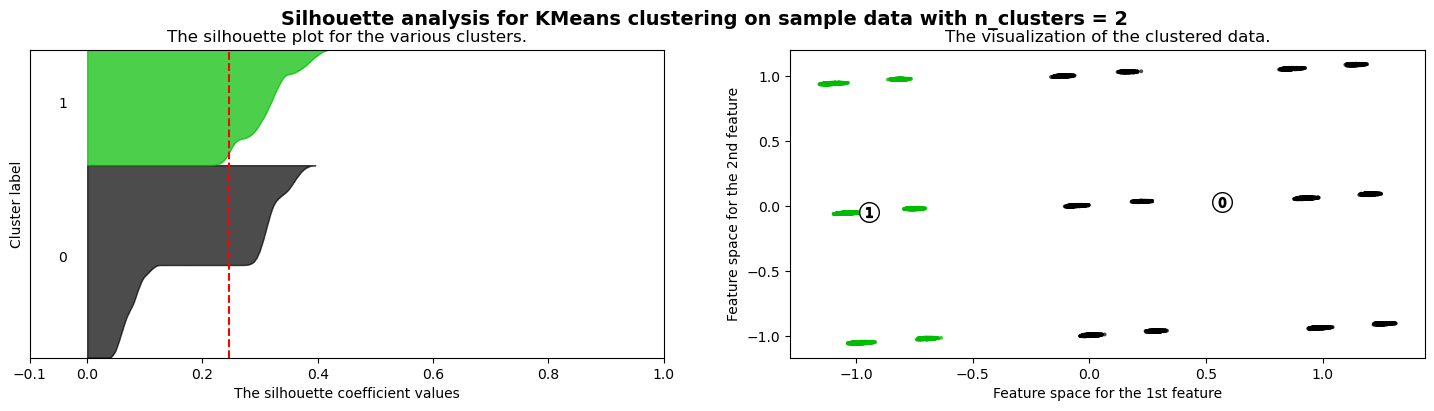

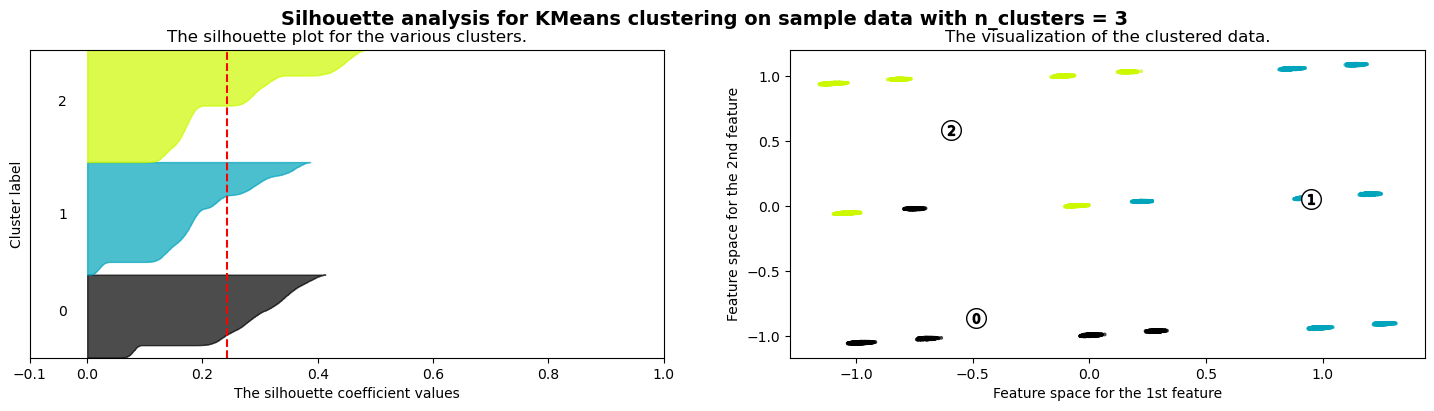

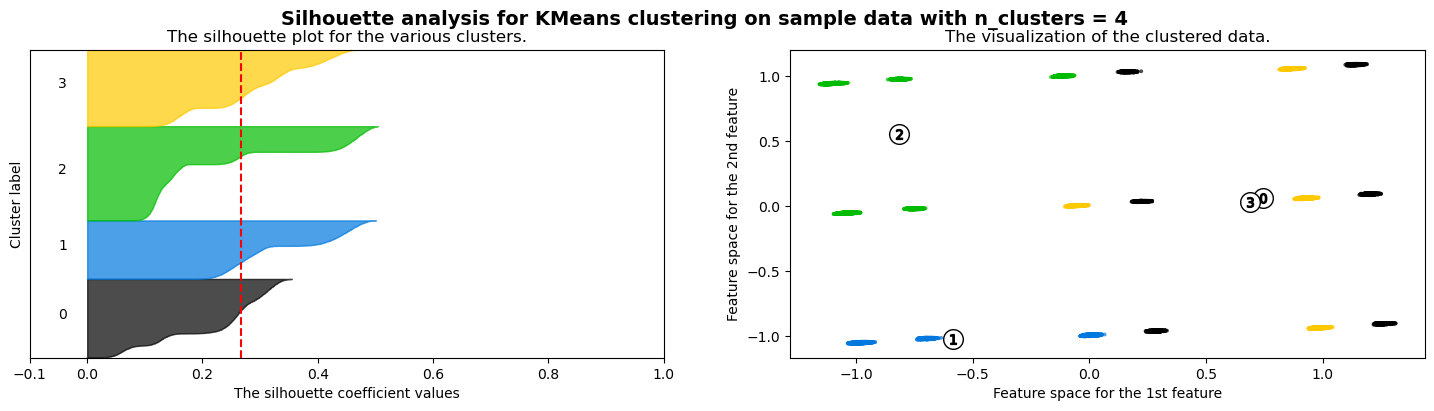

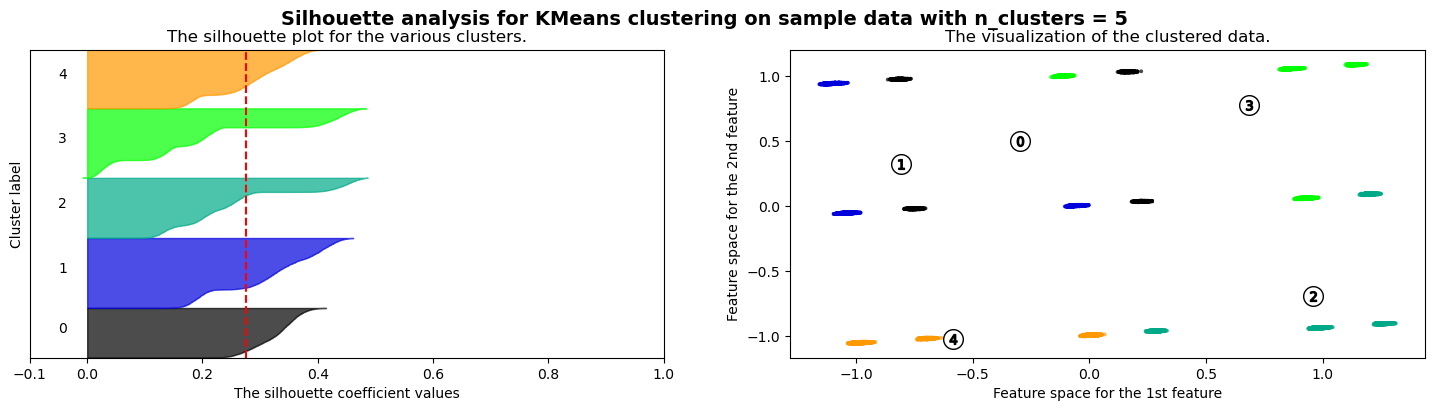

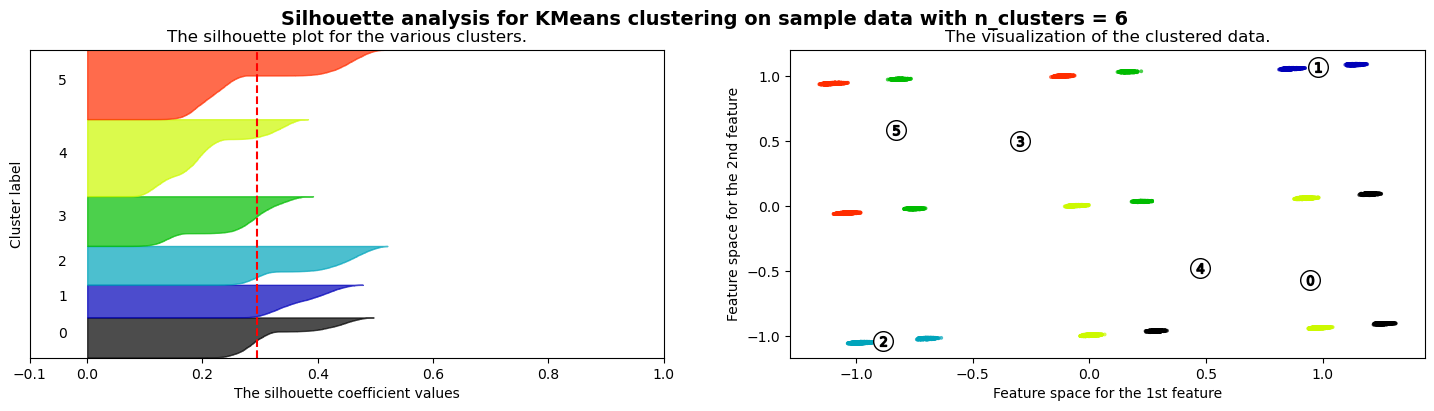

In [80]:
# call plot_silhouette func
plot_silhouette(range(2, max_cluster), df_model_final_pca, random_state)

## Init K-means with Optimal Cluster

In [88]:
# init model kmeans
km = KMeans(n_clusters = 3, init = "k-means++", max_iter = max_iter, n_init = n_init, random_state = random_state)

# Model Clustering

In [89]:
# fit optimal number of clusters (3)
km = km.fit(df_model_final_pca)

# predict cluster
pred = km.predict(df_model_final_pca)
pred

array([0, 0, 1, ..., 2, 2, 2], dtype=int32)

In [90]:
# insert clustering result into original dataset
df_clustered = df.copy()
df_clustered["cluster"] = pred
df_clustered

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn,cluster
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1,0
6,7,47,Female,37,15,9,28,Basic,Quarterly,574,14,1,0
10,11,46,Female,42,27,9,21,Standard,Annual,526,3,1,1
15,16,35,Female,1,3,7,3,Basic,Monthly,677,25,1,0
25,26,65,Female,58,7,3,30,Premium,Annual,166,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64369,64370,45,Female,33,12,6,21,Basic,Quarterly,947,14,1,0
64370,64371,37,Male,6,1,5,22,Standard,Annual,923,9,1,1
64371,64372,25,Male,39,14,8,30,Premium,Monthly,327,20,1,2
64372,64373,50,Female,18,19,7,22,Standard,Monthly,540,13,1,2


In [91]:
# save to csv
df_clustered.to_csv("dataset/df_churn_clustered.csv", index=False)

# EDA Cluster

## Cluster 0

In [92]:
# describe cluster 0
cluster_0 = df_clustered[df_clustered["cluster"] == 0]
cluster_0.describe().T

,count,mean,std,min,25%,50%,75%,max
customerid,8223.0,42354.539949,18416.112472,1.0,28561.0,49117.0,56937.5,64370.0
age,8223.0,42.874742,13.980000,18.0,31.0,44.0,55.0,65.0
tenure,8223.0,35.623252,16.284322,1.0,25.0,37.0,49.0,60.0
usage_frequency,8223.0,14.035267,9.063036,1.0,5.0,14.0,22.0,30.0
support_calls,8223.0,6.466861,2.668517,0.0,5.0,7.0,9.0,10.0
payment_delay,8223.0,22.401435,5.975706,0.0,19.0,23.0,27.0,30.0
total_spend,8223.0,535.100815,260.215448,100.0,309.0,520.0,763.0,1000.0
last_interaction,8223.0,15.516235,8.673849,1.0,8.0,15.0,23.0,30.0
churn,8223.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
cluster,8223.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


## Cluster 1

In [93]:
# describe cluster 1
cluster_1 = df_clustered[df_clustered["cluster"] == 1]
cluster_1.describe().T

,count,mean,std,min,25%,50%,75%,max
customerid,11153.0,42790.394154,18056.526738,11.0,30220.0,49191.0,56700.0,64371.0
age,11153.0,42.925043,14.131871,18.0,31.0,44.0,55.0,65.0
tenure,11153.0,36.208912,15.528700,1.0,26.0,38.0,49.0,60.0
usage_frequency,11153.0,13.458711,9.308803,1.0,4.0,13.0,22.0,30.0
support_calls,11153.0,6.626648,2.586546,0.0,5.0,7.0,9.0,10.0
payment_delay,11153.0,21.607101,6.588681,0.0,18.0,23.0,27.0,30.0
total_spend,11153.0,502.179593,261.019206,100.0,274.0,468.0,725.0,1000.0
last_interaction,11153.0,15.434502,8.629647,1.0,8.0,15.0,23.0,30.0
churn,11153.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
cluster,11153.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


## Cluster 2

In [94]:
# describe cluster 2
cluster_2 = df_clustered[df_clustered["cluster"] == 2]
cluster_2.describe().T

,count,mean,std,min,25%,50%,75%,max
customerid,11117.0,42497.365926,18198.736233,35.0,29392.0,49064.0,56645.0,64374.0
age,11117.0,42.900153,14.043336,18.0,31.0,44.0,55.0,65.0
tenure,11117.0,34.739318,16.184014,1.0,24.0,36.0,48.0,60.0
usage_frequency,11117.0,14.546011,8.977009,1.0,6.0,14.0,22.0,30.0
support_calls,11117.0,6.124854,2.873028,0.0,4.0,6.0,8.0,10.0
payment_delay,11117.0,23.015832,5.605968,0.0,20.0,24.0,27.0,30.0
total_spend,11117.0,524.887470,259.384134,100.0,299.0,500.0,749.0,1000.0
last_interaction,11117.0,15.480166,8.676739,1.0,8.0,15.0,23.0,30.0
churn,11117.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
cluster,11117.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
